# Michael Patterson Hubway project - DATA SCI 350
The aim of this project was to use Data Science skills to investigate a large data set. I chose the Hubway bike share from Boston as my data set (hubwaydatachallenge.org), and wanted to answer 4 questions:
1. What makes some stations gain or lose bikes over time?
2. Can I predict how many rides will be taken if I know the time and weather?
3. Do casual and registered members take similar length trips?
4. Does age effect drip duration?

(Note, graphs in this notebook may render poorly in Internet Explorer.)

## Load libraries and data
Load libraries and set the path

In [2]:
library(psych);
library(data.table);
library(raster)
library(ggplot2);
library(logging);
library(glmnet);
library(boot);
library(igraph);
setwd('C:\\Users\\Me\\Google Drive\\Science\\Data Science\\2nd quarter\\Final project')
source('Michael Patterson - Final project.R');

Load bike trips from hubway_trips.csv, which contains information about trips including the date and time, duration (in seconds), station ids, age of rider, and bike number. Then switch the datetime strings into separate fields for date and hour. This takes ~60 seconds on my computer.

In [3]:
trips <- load_trips()
trips <- clean_datetimes_trips(trips)
head(trips,3)

seq_id hubway_id status duration start_date strt_statn   end_date end_statn
1:      2         9 Closed      220 2011-07-28         23 2011-07-28        23
2:      4        11 Closed       64 2011-07-28         23 2011-07-28        23
3:     10        17 Closed     1108 2011-07-28         47 2011-07-28        40
   bike_nr subsc_type zip_code birth_date gender start_hour end_hour
1:  B00554 Registered   '02215       1966   Male         10       10
2:  B00554 Registered   '02116       1981 Female         10       10
3:  B00550 Registered   '01867       1994   Male         11       12
   day_of_week weekend
1:    Thursday       0
2:    Thursday       0
3:    Thursday       0

Load the station information from hubway_stations.csv

In [4]:
stations <- load_stations();
head(stations,3);

Warning message:
In .local(x, y, ...): Transforming SpatialPoints to the CRS of the Raster

id terminal                            station municipal      lat       lng
1:  3   B32006             Colleges of the Fenway    Boston 42.34002 -71.10081
2:  4   C32000        Tremont St. at Berkeley St.    Boston 42.34539 -71.06962
3:  5   B32012 Northeastern U / North Parking Lot    Boston 42.34181 -71.09018
     status elev
1: Existing    3
2: Existing    3
3: Existing    4

Load the weather information, including date, time, temperature, humidity, and conditions. This data was scraped from Weather Underground.

In [5]:
weather <- load_weather()
head(weather, 3)

temp humidity pressure visibility wind_dir wind_speed gust_speed
1:   73       61    29.98  10.000000    North        5.8          0
2:   68       87    30.02   6.463281    North        5.8          0
3:   70       68    29.99  10.000000      NNW        5.8          0
   precipitation    conditions start_date start_hour
1:             0 Partly_Cloudy 2011-07-28         01
2:             0         Clear 2011-07-28         02
3:             0         Clear 2011-07-28         03

Set the graph size to be somewhat smaller

In [6]:
options(repr.plot.width = 6)
options(repr.plot.height = 4)
gg_theme <- theme(axis.text.x = element_text(size = 12), axis.text.y = element_text(size = 12),
                                   axis.title.x = element_text(size = 16), axis.title.y = element_text(size = 16))

## How does elevation affect trips?
Some stations gain or lose bikes over time, as riders take one way trips. I wanted to know what factors influenced that. I started with the hypothesis that people like to ride downhill, which would mean stations at high elevations would lose bikes over time. To investigate this, I created a normalized net trips metric for each station, which is how often a bike is gained or lost on a per-trip basis. Since I'm going to do regression, I wanted to know whether this metric was normal, and plotted its quantile-quantile plot.

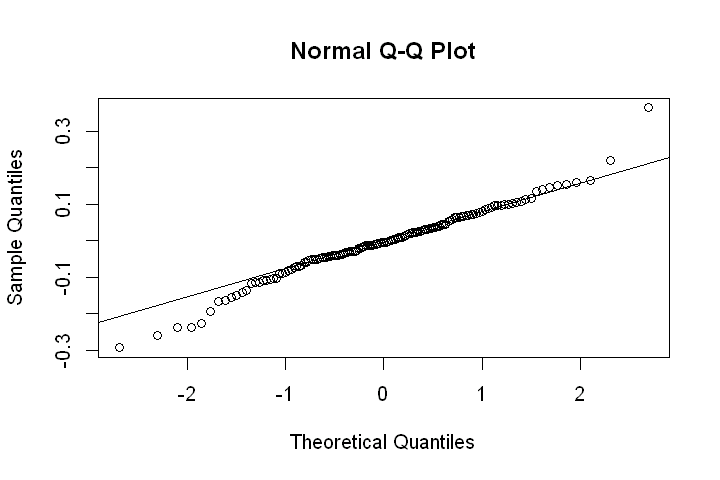

In [7]:
stations <- calc_trips_per_station(trips, stations)

While there are some outliers (and this distribution does not pass a Shapiro-Wilkes test, p=0.001), the data generally form a normal distribution. Now that we know the data is (mostly) normal, we can plot the net trips metric versus elevation. To save space, I will also fit it with a linear model.


Call:
lm(formula = norm_net_trips ~ elev, data = stations)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.24282 -0.05404 -0.00464  0.05061  0.39745 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.034121   0.011931   2.860  0.00489 ** 
elev        -0.005701   0.001364  -4.179 5.13e-05 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.08936 on 140 degrees of freedom
Multiple R-squared:  0.1109,	Adjusted R-squared:  0.1046 
F-statistic: 17.47 on 1 and 140 DF,  p-value: 5.127e-05


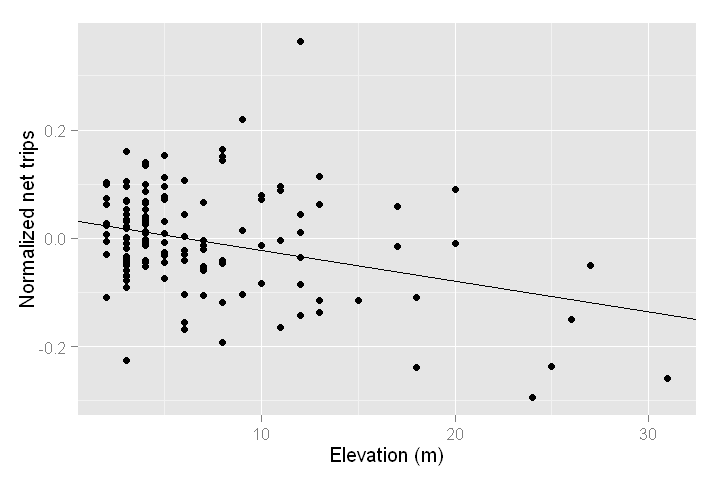

In [8]:
elev_plot <-qplot(elev, norm_net_trips, data = stations)
elev_model <- lm(norm_net_trips ~ elev, data = stations)
elev_plot + geom_abline(intercept = elev_model$coefficients[1], slope = elev_model$coefficients[2])+ xlab('Elevation (m)')+ ylab('Normalized net trips')
summary(elev_model)

It looks like the stations at high elevations lose bikes! The R-squared only explains 11% of the variance, but the fit is highly significant. With a slope of -0.0057, this means that for every 10 meters higher a station is, it will lose 5% of its bikes on a per-trip basis.

While the fit was significant, I was concerned that the stations at high elevation might be unduly influencing the regression, so I plotted the residuals.

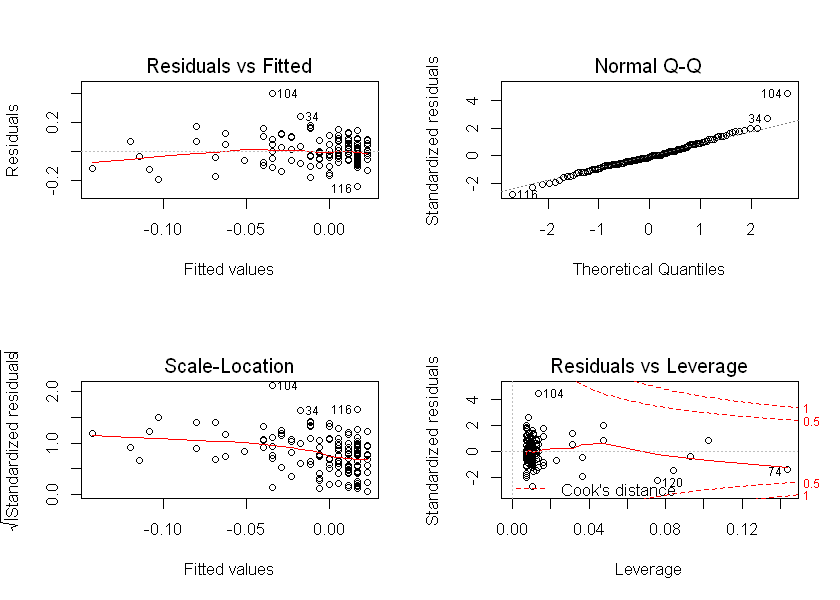

In [27]:
par(mfrow=c(2,2))
plot(elev_model)
par(mfrow=c(1,1))

While the residuals do not pass the Shapiro-Wilkes test (p=0.005), they look ok to my eye. The residuals vs fitted values curve is flat, and the QQ plot is mostly normal. All points had Cook's distances < 0.5. Still, I wanted to be sure that the high elevation points were not too influential, so I bootstrapped the regression 1000 times, and plotted a histogram of the slope coefficients.

BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 1000 bootstrap replicates

CALL : 
boot.ci(boot.out = boot_elev, type = "basic", index = 2)

Intervals : 
Level      Basic         
95%   (-0.0100, -0.0025 )  
Calculations and Intervals on Original Scale


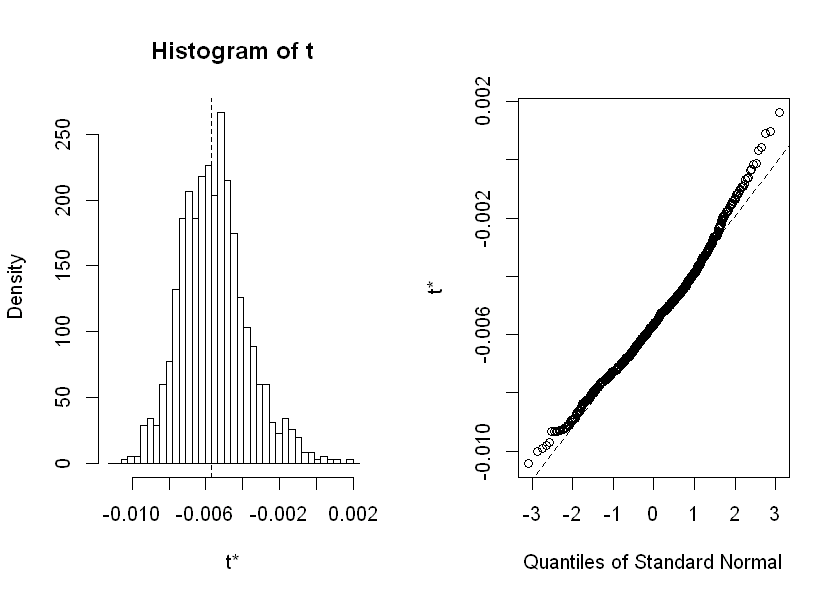

In [25]:
n_boot <- 1000
boot_func <- function(formula, data, indices) {
    data_sample <- data[indices, ] # select a sample
    fit <- lm(formula, data = data_sample)
    return(coef(fit))
  }
boot_elev <- boot(data = stations, statistic = boot_func,
                    R=n_boot, formula= norm_net_trips ~ elev) 
plot(boot_elev, index = 2)
print(boot.ci(boot_elev, type = 'basic', index = 2))

As the text and histogram above show, the 95% confidence interval of the slope does not cross zero, so it looks like those high elevation stations are not overly influencing the fit. We can confidently say that people prefer to bike downhill, and that stations lose ~5% of their bikes on a per-trip basis for every 10m higher they are.

I was curious to see if there were other influencing variables, so as a second feature I chose the average time of day of trips. To calculate the average time of day, I calculated the circular mean of trip start times (the circular median is surprisingly computationally intensive to calculate!). I then plotted the net trips versus start time, and fit with a linear model.


Call:
lm(formula = norm_net_trips ~ circ_start_time, data = stations)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.28666 -0.04871  0.00199  0.06115  0.37281 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)
(Intercept)     -0.030746   0.068972  -0.446    0.656
circ_start_time  0.001743   0.004576   0.381    0.704

Residual standard error: 0.09543 on 137 degrees of freedom
Multiple R-squared:  0.001057,	Adjusted R-squared:  -0.006234 
F-statistic: 0.145 on 1 and 137 DF,  p-value: 0.7039



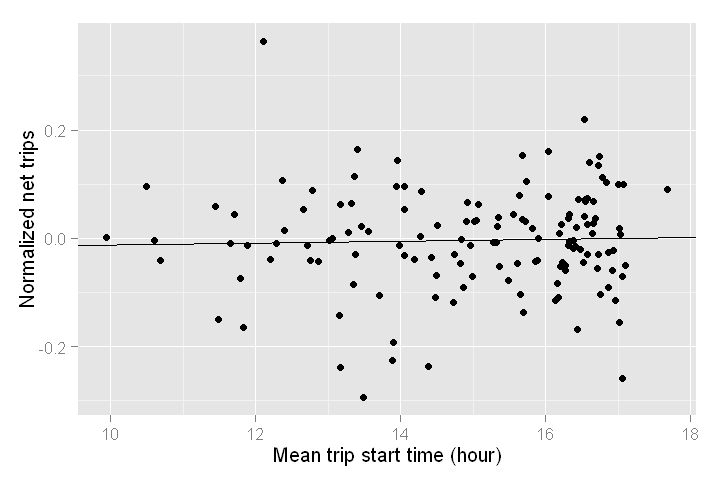

In [42]:
circ_start_times = trips[, circadian.mean(as.numeric(start_hour)), by='strt_statn']
# rename columns for the merge, then merge by station
setnames(circ_start_times, c('strt_statn', 'V1'), c('id', 'circ_start_time') )
stations <- merge(stations, circ_start_times, by = 'id')

# now fit and plot
time_model <- lm(norm_net_trips ~ circ_start_time, data = stations)
start_time_plot <- qplot(circ_start_time,norm_net_trips, data=stations) + xlab('Mean trip start time (hour)')+ ylab('Normalized net trips')
print(summary(time_model))
start_time_plot + geom_abline(intercept = time_model$coefficients[1], slope = time_model$coefficients[2])

There does not seem to be any relationships between trip start time and bikes lost.
## Trips / hour analysis

The second question I wanted to answer was how well I could predict the # of rides taken in an hour given the time of day and weather. To do this I first needed to sum the number of trips per hour, then I needed to merge the trip data frame with the weather data frame. Here I merged with the all.x flag = TRUE to keep cold nights when no one biked.

Once that's calculated, let's do some data exploration and plot the number of trips per hour depending on the weather.

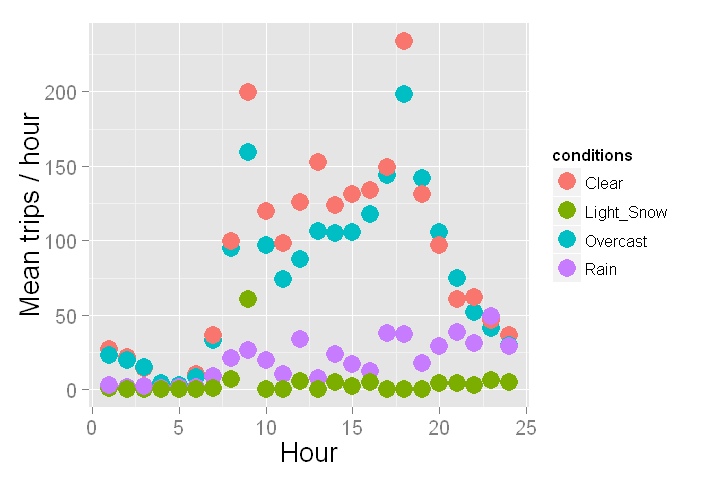

In [48]:
trips_per_hour_all <- sum_trips_merge_weather(trips, weather, allx_flag = TRUE)
  
# aggregate the trips by weather conditions, and plot the trips per hour depending on the weather
trips_by_condition <- trips_per_hour_all[, list(mean_trips = mean(sum_trips)), by =c('start_hour', 'conditions')]
conditions_per_hour_plot <- qplot(as.numeric(start_hour), mean_trips, data = trips_by_condition[conditions %in% c('Clear', 'Overcast','Rain', 'Light_Snow')],
                                  color = conditions) + geom_point(size=5) + xlab('Hour') + ylab('Mean trips / hour')
conditions_per_hour_plot + gg_theme

As one might expect, more trips are taken during the day, especially around rush hour. Furthermore, people like to bike when it's not precipitating! Interestingly, the bike "rush hour" is 6 o'clock; perhaps people wait to bike after traffic dies down a bit. This seems like we should be able to model it. Since there is a big rush hour dependence, let's also see how the trips breakdown for weekdays vs weekends.

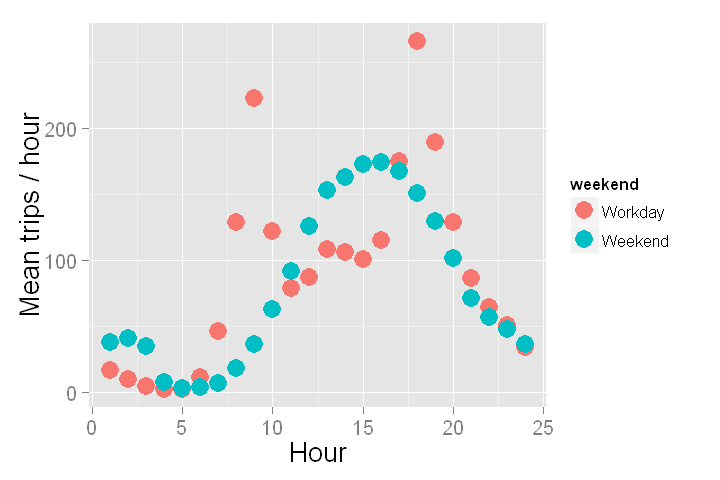

In [49]:
# aggregate trips by weekend, and plot it vs hour
trips_by_weekend <- trips_per_hour_all[, list(mean_trips = mean(sum_trips)), by =c('start_hour', 'weekend')]
weekend_plot <- qplot(as.numeric(start_hour), mean_trips, data = trips_by_weekend, color = weekend) + geom_point(size=5)
weekend_plot + xlab('Hour') + ylab('Mean trips / hour') + gg_theme

There's a pretty big difference in weekend vs weekday traffic! Few people like to bike before ten if they're not working.

Now that we know we have some features to model, let's start modeling. First, though, let's see how our dependent variable is distributed.

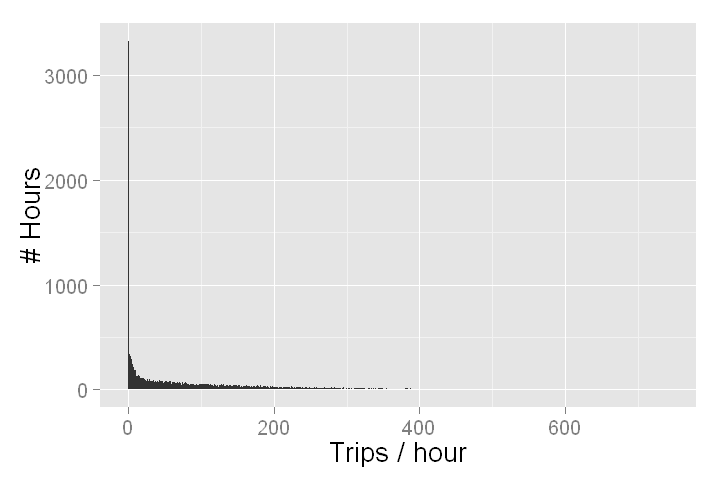

In [53]:
trips_distribution_all <- qplot(sum_trips, data = trips_per_hour_all, geom='histogram', binwidth=1) + xlab('Trips / hour') + ylab('# Hours')
trips_distribution_all + gg_theme

Oh no! Our data is dominated by hours when no one takes any trips at all! That will not make modeling easy. It's possible to  model this data with a zero-inflated negative binomial model, but for this notebook let's keep it simple and use a regular linear model. To do that, though, let's make a new data frame that only includes hours where people actually took a bike trip. Then let's plot the # of trips using different normalization techniques like log or square root.

stat_bin: binwidth defaulted to range/30. Use 'binwidth = x' to adjust this.


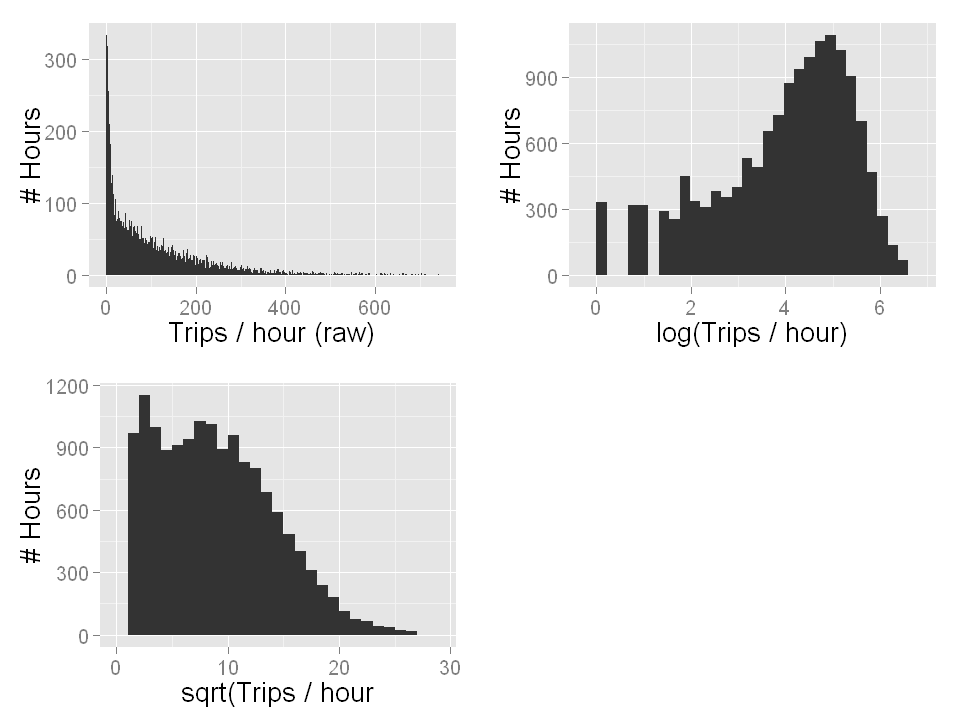

In [9]:
trips_per_hour <- sum_trips_merge_weather(trips, weather, allx_flag = FALSE)

# make graphs a little bigger
options(repr.plot.width = 8)
options(repr.plot.height = 6)

# plot normalized trips length 
plot1 <- qplot(sum_trips, data = trips_per_hour, geom='histogram', binwidth = 1) + xlab('Trips / hour (raw)') + ylab('# Hours') +gg_theme
plot2 <- qplot(sqrt(sum_trips), data = trips_per_hour, geom='histogram', binwidth = 1) + xlab('sqrt(Trips / hour') + ylab('# Hours') +gg_theme
plot3 <- qplot(log(sum_trips), data = trips_per_hour, geom='histogram') + xlab('log(Trips / hour)') + ylab('# Hours') +gg_theme
multiplot(plot1, plot2, plot3, cols = 2)


Neither the square root or log normalization look great. What if we plot their quantile-quantile distributions?

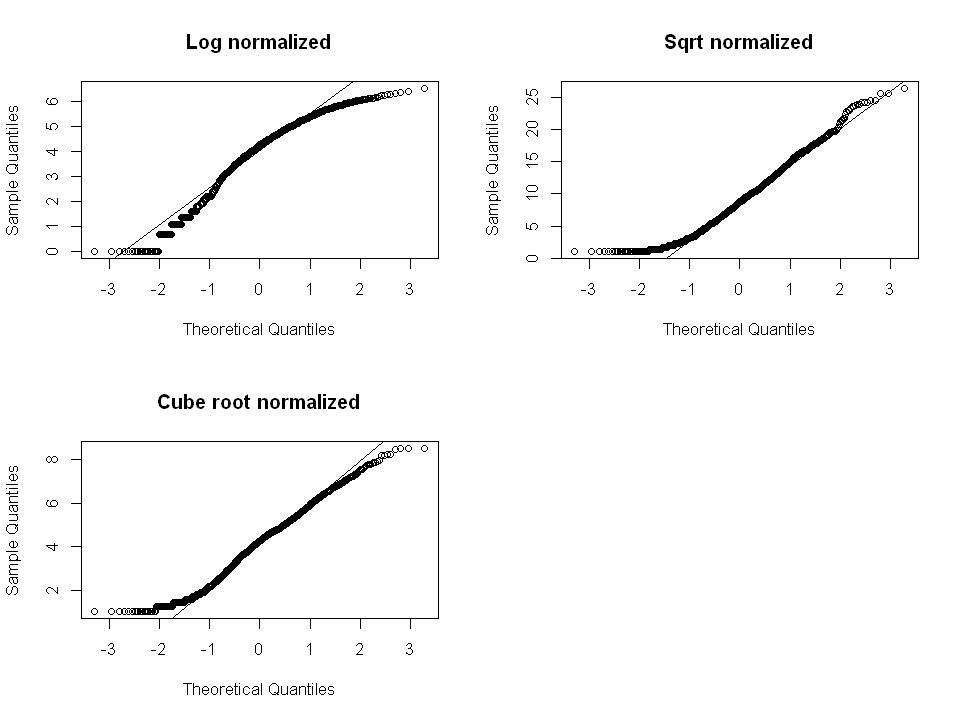

In [67]:
par(mfrow=c(2,2))
qqnorm(sample(log(trips_per_hour$sum_trips), 1000), main = 'Log normalized')
qqline(log(trips_per_hour$sum_trips))
qqnorm(sample(sqrt(trips_per_hour$sum_trips), 1000), main = 'Sqrt normalized')
qqline(sqrt(trips_per_hour$sum_trips))
qqnorm(sample((trips_per_hour$sum_trips) ^ (1/3), 1000), main = 'Cube root normalized')
qqline((trips_per_hour$sum_trips) ^ (1/3))
par(mfrow=c(1,1))

In [18]:
# return graphs to original size
options(repr.plot.width = 6)
options(repr.plot.height = 4)

The log transofmr is obviously bad. However, the square root normalization is pretty good for 3 standard deviation. Since we're already approximating by using a linear model, let's just go with the square root normalization. Now we're ready to fit the data! Here we are going to model the hour of the day, the weather (including temperature, conditions, and wind), and also whether it was a weekend or weekday. I'm leaving out day of week since it is collinear with the weekend.

In [10]:
naive_conditions_model <- lm(sqrt(sum_trips) ~ . - start_date -day_of_week, data = trips_per_hour )
summary(naive_conditions_model)
paste('AIC = ', AIC(naive_conditions_model))


Call:
lm(formula = sqrt(sum_trips) ~ . - start_date - day_of_week, 
    data = trips_per_hour)

Residuals:
     Min       1Q   Median       3Q      Max 
-12.0384  -2.0892  -0.1759   1.9711  12.2379 

Coefficients:
                             Estimate Std. Error t value Pr(>|t|)    
(Intercept)                -54.058902   4.463818 -12.110  < 2e-16 ***
start_hour01                -0.569983   0.185325  -3.076 0.002105 ** 
start_hour02                -1.249869   0.187199  -6.677 2.53e-11 ***
start_hour03                -2.612738   0.190762 -13.696  < 2e-16 ***
start_hour04                -2.818041   0.192326 -14.652  < 2e-16 ***
start_hour05                -1.487296   0.187188  -7.945 2.08e-15 ***
start_hour06                 1.320149   0.185282   7.125 1.09e-12 ***
start_hour07                 5.047339   0.185079  27.271  < 2e-16 ***
start_hour08                 8.009287   0.184655  43.374  < 2e-16 ***
start_hour09                 5.505319   0.185191  29.728  < 2e-16 ***
start_hour10   

[1] "AIC =  75968.6544583017"

With an R-square of 0.62, we can account for 62% of the variance of trips taken, pretty good! Our AIC is 75968. However, there are a lot of variables here. Let's try to reduce the number of variables using a lasso regression. Here I'm taking the coefficients from the lambda 1 SE.

61 x 1 sparse Matrix of class "dgCMatrix"
                                     1
(Intercept)                 6.75954480
(Intercept)                 .         
start_hour01               -1.83540048
start_hour02               -2.50708053
start_hour03               -3.85844514
start_hour04               -4.05308211
start_hour05               -2.71811456
start_hour06                .         
start_hour07                3.52517864
start_hour08                6.46444283
start_hour09                3.94103581
start_hour10                2.51191818
start_hour11                3.13721077
start_hour12                4.14327364
start_hour13                4.13128914
start_hour14                3.92183058
start_hour15                4.48316436
start_hour16                6.41514589
start_hour17                8.49240837
start_hour18                6.40518100
start_hour19                4.41817722
start_hour20                2.58583634
start_hour21                1.45331838
start_hour22          

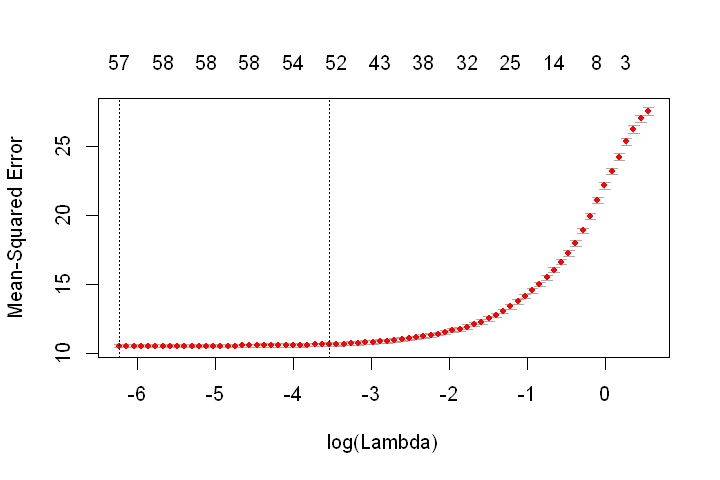

In [19]:
# for lassoed regression, you need to scale your features, and turn the data frame into a matrix
scale_cols <- c('temp', 'humidity', 'pressure', 'visibility', 'wind_speed', 'gust_speed', 'precipitation')
scale_trips <- trips_per_hour[, (scale_cols) := lapply(.SD, scale), .SDcols = scale_cols]
glm_matrix <- model.matrix(~ . - sum_trips - start_date - day_of_week, scale_trips)

# now do a lasso model
cv_lasso_model <- cv.glmnet(glm_matrix, sqrt(trips_per_hour$sum_trips), alpha = 1, family ='gaussian')
plot(cv_lasso_model)
print(coef(cv_lasso_model, s = 'lambda.1se'))

Oh my, all the coefficients are significant! We can't get ride of any terms without losing too much information. Well, I have one more idea to improve the model. People on the weekend take different trips from people during the week. Let's include an interaction term for the weekend, hour, and weather conditions.

In [11]:
weekend_conditions_model <- lm(sqrt(sum_trips) ~ . - start_date -day_of_week + weekend*start_hour, data = trips_per_hour )
paste('R-squared: ', summary(weekend_conditions_model)$r.squared)
paste('AIC = ', AIC(weekend_conditions_model))

[1] "R-squared:  0.701914378588397"

[1] "AIC =  72529.517620449"

With the interaction term, the R<sup>2</sup> has increased to 0.7, and the AIC is down to 72,530, a decent improvement for adding a few terms. We could probably improve this model more by including things like how long Hubway has existed (since more people will ride as they are exposed to it). For a simple model, though, I think this does a good job of predicitng how often people use the service.

## Casual vs member trips

With that somewhat complicated analysis out of the way, I'd like to answer a couple simpler question, starting with a comparison of trip duration for casual vs member riders. Let's start by plotting a histogram of trip duration.

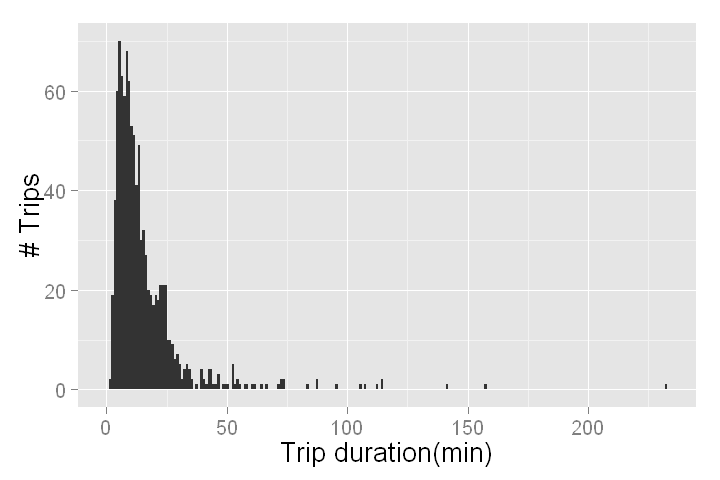

In [21]:
duration_plot <- qplot(duration / 60, data = trips[sample(nrow(trips), 1000),], geom = 'histogram', binwidth = 1) + xlab('Trip duration(min)')+ ylab('# Trips')
duration_plot + gg_theme

This distribution is not as bad as the trips / hour one, but is clearly not normal. We will deal with that later. For now, though, we can plot the cumulative distribution of trip lengths for casual versus member trips.

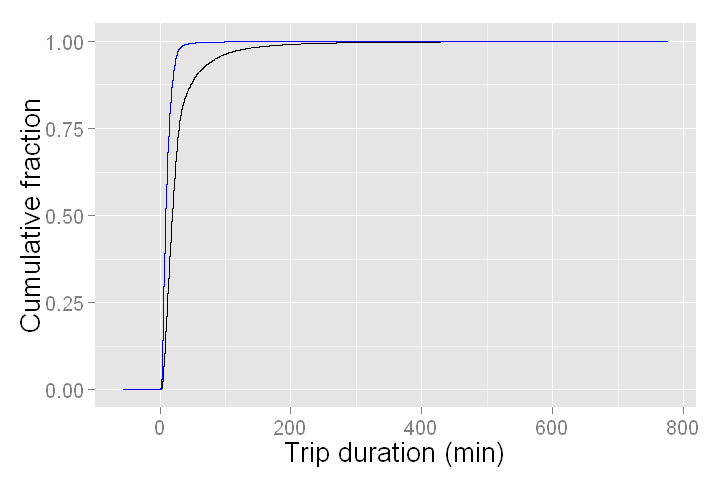

In [43]:
casual_duration <- trips$duration[trips$subsc_type == 'Casual'] / 60
member_duration <- trips$duration[trips$subsc_type == 'Registered'] / 60
duration_plot<-ggplot() +  stat_ecdf( aes(sample(casual_duration), 1000)) + stat_ecdf( aes(sample(member_duration), 1000), color = 'blue')
member_plot + xlab('Trip duration (min)') + ylab('Cumulative fraction') + gg_theme

Suprisingly (to me at least), casual riders take longer trips than registered riders! Registered riders probably use the bikes more for commuting, while casual riders may be using the bikes to tour the city. Since the data isn't normal we can't use the standard t-test, but we can use a K-S test. I can tell you from looking at the graph it's gonna be significant.

In [44]:
ks.test(casual_duration, member_duration)

Warning message:
In ks.test(casual_duration, member_duration): p-value will be approximate in the presence of ties


	Two-sample Kolmogorov-Smirnov test

data:  casual_duration and member_duration
D = 0.41222, p-value < 2.2e-16
alternative hypothesis: two-sided


## Age vs trip duration

The final question I wanted to answer was whether rider age was correlated with trip length. I thought that older riders might take shorter trips. To look at this we do need to correctly normalize the trip duration data. Let's plot the trip duration quantile-quantile plots under different normalizations.

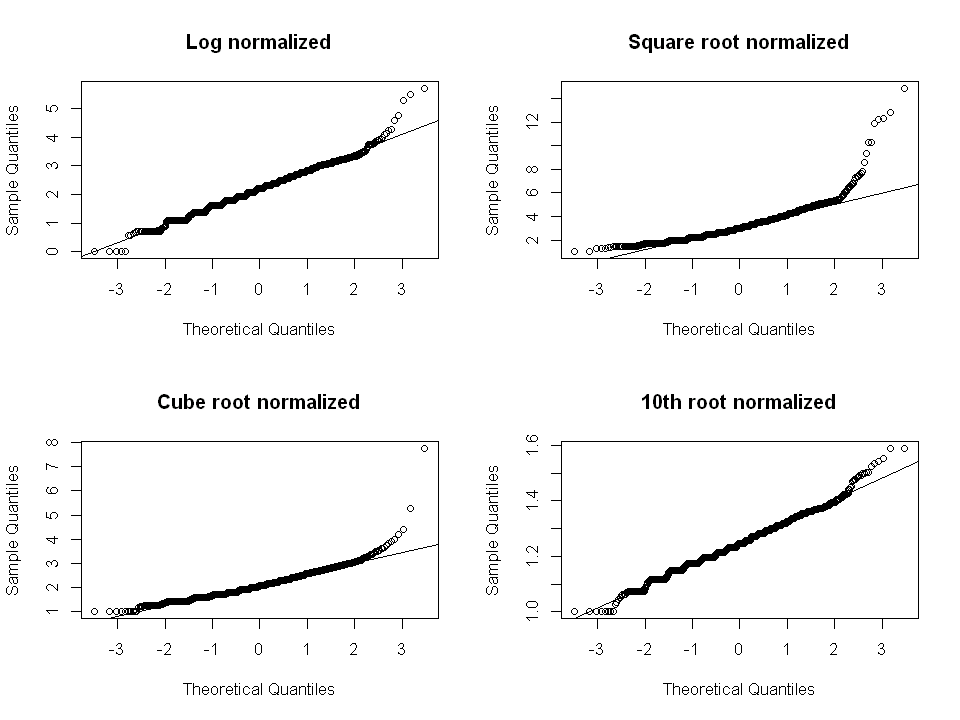

In [46]:
# make graphs a little bigger
options(repr.plot.width = 8)
options(repr.plot.height = 6)

# plot the normalized trip durations
par(mfrow=c(2,2))
qqnorm(log(sample(member_duration, 2000)), main = 'Log normalized')
qqline(log(sample(member_duration, 2000)))
qqnorm(sqrt(sample(member_duration, 2000)), main = 'Square root normalized')
qqline(sqrt(sample(member_duration, 2000)))
qqnorm((sample(member_duration, 2000))^(1/3), main = 'Cube root normalized')
qqline((sample(member_duration, 2000))^(1/3))
qqnorm((sample(member_duration, 2000))^(1/10), main = '10th root normalized')
qqline((sample(member_duration, 2000))^(1/10))
par(mfrow=c(1,1))

Here the log normalization seems most appropriate. Now we can plot the log of trip duration versus age (as determined by birthdate). While we're at it, let's model the relationship as well.


Call:
lm(formula = log(duration) ~ birth_date, data = member_trips)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.2300 -0.4317 -0.0097  0.4300  4.3744 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) 10.0977146  0.1980180   50.99   <2e-16 ***
birth_date  -0.0019262  0.0001002  -19.22   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.6494 on 346948 degrees of freedom
Multiple R-squared:  0.001064,	Adjusted R-squared:  0.001061 
F-statistic: 369.6 on 1 and 346948 DF,  p-value: < 2.2e-16


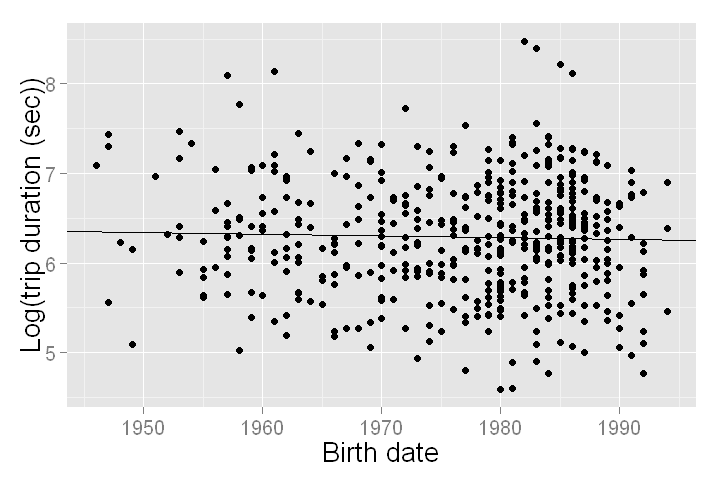

In [56]:
member_trips <- trips[trips$subsc_type == 'Registered' & !is.na(trips$birth_date) ]
age_model <- lm(log(duration) ~ birth_date, member_trips)
summary(age_model)

# reset graph size
options(repr.plot.width = 6)
options(repr.plot.height = 4)

sample_trips <- member_trips[sample(nrow(member_trips), 500)] # only a sample for plotting
age_plot <- qplot( birth_date, log(duration), data = sample_trips, xlab = 'Birth date', ylab = 'Log(trip duration (sec))')
age_plot + geom_abline(intercept = age_model$coefficients[1], slope = age_model$coefficients[2]) + gg_theme

While the model returned a p-value of zero, the R<sup>2</sup> was 0.001, which means that there is no meaningful correlation. Biking is ageless.

That's it for my final project. In the first part I showed that people prefer to ride downhill. Then I modeled the number of trips taken per hour depending on the weather and time, and was able to account for 70% of the variability. I showed that casual riders take longer trips than member riders. Finally, I showed that age does not correlate with trip duration.

If I were to take this further, I would like to try using graph models of stations, to see how people travel between them. I would also like to correlate trips with local events, although that would require getting an event data set (perhaps baseball games or concerts?).

For any questions or further ideas, please contact me at map222 at gmail.